# Breast Cancer Classification with MobileNetV2

This notebook demonstrates a complete deep learning workflow for classifying breast cancer images as benign or malignant using the CBIS-DDSM dataset. The workflow includes:

- Loading and preprocessing image data and labels from CSV files
- Mapping image paths and cleaning the dataset
- Splitting data into training, validation, and test sets
- Building a transfer learning model using MobileNetV2
- Training, evaluating, and reporting model performance with metrics such as accuracy, precision, recall, confusion matrix, and ROC curve

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
import glob # For finding image files

# --- Configuration ---
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
BASE_DATA_PATH = os.path.join(PROJECT_ROOT, 'data')

# Paths to CSV files
CSV_DIR = os.path.join(BASE_DATA_PATH, 'csv')
DICOM_INFO_PATH = os.path.join(CSV_DIR, 'dicom_info.csv')
MASS_TRAIN_PATH = os.path.join(CSV_DIR, 'mass_case_description_train_set.csv')
CALC_TRAIN_PATH = os.path.join(CSV_DIR, 'calc_case_description_train_set.csv')
MASS_TEST_PATH = os.path.join(CSV_DIR, 'mass_case_description_test_set.csv')
CALC_TEST_PATH = os.path.join(CSV_DIR, 'calc_case_description_test_set.csv')


# Path to the root directory where CBIS-DDSM JPEG images are stored
CBIS_DDSM_JPEG_ROOT = os.path.join(BASE_DATA_PATH, 'kaggle/jpeg')


# --- Load Data ---
try:
    dicom_df = pd.read_csv(DICOM_INFO_PATH)
    mass_train_df = pd.read_csv(MASS_TRAIN_PATH)
    calc_train_df = pd.read_csv(CALC_TRAIN_PATH)

    print(f"Successfully loaded CSV files.")
    print(f"Project Root: {PROJECT_ROOT}")
    print(f"Base Data Path: {BASE_DATA_PATH}")
    print(f"CSV Directory: {CSV_DIR}")
    print(f"CBIS-DDSM JPEG Root: {CBIS_DDSM_JPEG_ROOT}")

    print("\n--- Dicom Info DataFrame Head ---")
    print(dicom_df.head())

    print("\n--- Mass Train DataFrame Head ---")
    print(mass_train_df.head())

    print("\n--- Calc Train DataFrame Head ---")
    print(calc_train_df.head())

except FileNotFoundError as e:
    print(f"Error loading CSV files: {e}")
    print(f"Please ensure the following paths are correct and files exist:")
    print(f"DICOM_INFO_PATH: {DICOM_INFO_PATH}")
    print(f"MASS_TRAIN_PATH: {MASS_TRAIN_PATH}")
    print(f"CALC_TRAIN_PATH: {CALC_TRAIN_PATH}")
    print(f"CBIS_DDSM_JPEG_ROOT: {CBIS_DDSM_JPEG_ROOT} (and its subdirectories)")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

Successfully loaded CSV files.
Project Root: d:\Computer Science\UoL\Final Project\Prototype
Base Data Path: d:\Computer Science\UoL\Final Project\Prototype\data
CSV Directory: d:\Computer Science\UoL\Final Project\Prototype\data\csv
CBIS-DDSM JPEG Root: d:\Computer Science\UoL\Final Project\Prototype\data\kaggle/jpeg

--- Dicom Info DataFrame Head ---
                                           file_path  \
0  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...   
1  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...   
2  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...   
3  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...   
4  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...   

                                          image_path  AccessionNumber  \
0  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...              NaN   
1  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...              NaN   
2  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...              NaN   
3  CBIS-DDSM/jpe

In [14]:
# 1. Build a mapping dictionary from Case Identifier to full JPEG paths for CROPPED images
print("--- Building Case Identifier to Cropped JPEG Path Dictionary ---")
case_identifier_to_jpeg_path_dict = {}
cropped_dicom_info = dicom_df[dicom_df["SeriesDescription"] == "cropped images"].copy()

# Drop rows where essential information for mapping might be missing
cropped_dicom_info.dropna(subset=['PatientID', 'image_path'], inplace=True)

processed_patient_ids = set() # To handle cases where a PatientID might have multiple "cropped images"
for index, row in cropped_dicom_info.iterrows():
    case_id = str(row['PatientID']) # e.g., Mass-Training_P_00001_LEFT_CC_1
    relative_jpeg_path = str(row['image_path'])
    
    full_jpeg_path = os.path.normpath(relative_jpeg_path.replace('CBIS-DDSM/jpeg', CBIS_DDSM_JPEG_ROOT))
    
    if os.path.exists(full_jpeg_path):
        if case_id not in case_identifier_to_jpeg_path_dict:
            case_identifier_to_jpeg_path_dict[case_id] = full_jpeg_path
        # else:
            # This case_id already has a cropped image. This might happen if the same case
            # has multiple "cropped image" entries in dicom_df. We'll use the first one.
            # print(f"Warning: Duplicate Case ID '{case_id}' found for cropped images. Using first encountered path.")
            # print(f"  Existing path: {case_identifier_to_jpeg_path_dict[case_id]}")
            # print(f"  New path (ignored): {full_jpeg_path}")
            pass # Keep the first one encountered
    # else:
        # print(f"Warning: Cropped JPEG file not found for Case ID {case_id} at {full_jpeg_path}")

print(f"Built dictionary with {len(case_identifier_to_jpeg_path_dict)} entries for cropped images.")
# Display a few items from the map for verification
print("\nSample entries from case_identifier_to_jpeg_path_dict:")
for i, (uid, path) in enumerate(case_identifier_to_jpeg_path_dict.items()):
    if i < 3:
        print(f"  Key (Case ID from dicom_df['PatientID']): {uid}")
        print(f"  Value (Constructed JPEG Path): {path}")
        print(f"  Does this path exist? {os.path.exists(path)}")
    else:
        break

--- Building Case Identifier to Cropped JPEG Path Dictionary ---
Built dictionary with 3567 entries for cropped images.

Sample entries from case_identifier_to_jpeg_path_dict:
  Key (Case ID from dicom_df['PatientID']): Mass-Training_P_01265_RIGHT_MLO_1
  Value (Constructed JPEG Path): d:\Computer Science\UoL\Final Project\Prototype\data\kaggle\jpeg\1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304\1-172.jpg
  Does this path exist? True
  Key (Case ID from dicom_df['PatientID']): Calc-Test_P_00562_LEFT_CC_2
  Value (Constructed JPEG Path): d:\Computer Science\UoL\Final Project\Prototype\data\kaggle\jpeg\1.3.6.1.4.1.9590.100.1.2.381187369611524586537789902641525311317\1-052.jpg
  Does this path exist? True
  Key (Case ID from dicom_df['PatientID']): Calc-Training_P_00181_RIGHT_CC_1
  Value (Constructed JPEG Path): d:\Computer Science\UoL\Final Project\Prototype\data\kaggle\jpeg\1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138\1-034.jpg
  Does this path exi

In [ ]:
# 2. MODIFIED Function to extract JPEG paths and labels using the new dictionary
def get_jpeg_paths_and_labels_revised(df, patient_id_col_original_df, dicom_path_col, pathology_col, case_id_dict):
    processed_records = []
    valid_paths_found = 0
    skipped_due_to_missing_path_str = 0
    skipped_due_to_index_error = 0 # For path splitting issues
    skipped_due_to_key_not_in_dict = 0
    skipped_due_to_path_not_exist = 0 # Should be caught by dict creation mostly
    
    print(f"\n--- Debugging get_jpeg_paths_and_labels_revised (first few rows) ---")
    print(f"Total rows to process: {len(df)}")
    print(f"Size of case_id_dict: {len(case_id_dict)}")

    for index, row in df.iterrows():
        # For brevity, debug prints only for first few rows
        debug_print = index < 5 

        original_patient_id = row[patient_id_col_original_df] # e.g. P_00001
        dicom_path_str = row[dicom_path_col] # e.g. Mass-Training_P_00001_LEFT_CC_1/...
        pathology = row[pathology_col]

        if pd.isna(dicom_path_str) or not isinstance(dicom_path_str, str):
            if debug_print: print(f"Row {index}: Skipping: DICOM path string is NaN or not a string: {dicom_path_str}")
            skipped_due_to_missing_path_str += 1
            continue

        if debug_print: print(f"\nRow {index}, Original Patient ID: {original_patient_id}")
        if debug_print: print(f"  DICOM path string from CSV: {dicom_path_str}")

        try:
            path_parts = dicom_path_str.split('/')
            if not path_parts: # Check if split produced anything
                if debug_print: print(f"  Skipping: DICOM path string is empty or invalid after split: {path_parts}")
                skipped_due_to_index_error +=1
                continue
            
            case_id_key = path_parts[0] # e.g., Mass-Training_P_00001_LEFT_CC_1
            if debug_print: print(f"  Extracted Case ID Key for lookup: {case_id_key}")
            
            jpeg_path = case_id_dict.get(case_id_key)
            
            if jpeg_path: # Key found in dict
                # os.path.exists was already checked during dict creation, but good for sanity
                if debug_print: print(f"  Found in case_id_dict. Mapped JPEG Path: {jpeg_path}")
                if os.path.exists(jpeg_path): # Final check
                    if debug_print: print(f"  SUCCESS: JPEG path exists.")
                    processed_records.append({
                        'patient_id': original_patient_id, # Store the P_XXXXX style ID
                        'image_path': jpeg_path,
                        'pathology': pathology,
                        'case_id_from_path': case_id_key # For verification
                    })
                    valid_paths_found += 1
                else: # Should be rare if dict creation is robust
                    if debug_print: print(f"  Skipping: Mapped JPEG path '{jpeg_path}' does NOT exist on disk (should have been caught earlier).")
                    skipped_due_to_path_not_exist += 1
            else: # Key not found
                if debug_print: print(f"  Skipping: Case ID Key '{case_id_key}' NOT found in case_id_dict.")
                skipped_due_to_key_not_in_dict += 1
        except Exception as e: # Catch any other errors during processing
            if debug_print: print(f"  Skipping: Exception during processing: {e}")
            # Increment a general error counter or a specific one if you add more try-except blocks
            skipped_due_to_index_error +=1 # Re-using this for general processing errors for now

    total_skipped = skipped_due_to_missing_path_str + skipped_due_to_index_error + \
                    skipped_due_to_key_not_in_dict + skipped_due_to_path_not_exist
                    
    print(f"\n  Summary for this DataFrame:")
    print(f"  Found {valid_paths_found} valid JPEG paths.")
    print(f"  Total skipped entries: {total_skipped}")
    print(f"    Skipped due to missing/invalid DICOM path string: {skipped_due_to_missing_path_str}")
    print(f"    Skipped due to path format/other processing error: {skipped_due_to_index_error}")
    print(f"    Skipped due to Case ID Key not in dict: {skipped_due_to_key_not_in_dict}")
    print(f"    Skipped due to mapped JPEG path not existing on disk: {skipped_due_to_path_not_exist}")
    return pd.DataFrame(processed_records)

In [16]:
# 3. Apply to mass_train_df and calc_train_df (USING THE REVISED FUNCTION)
print("\n--- Processing mass_train_df with REVISED logic ---")
mass_df_processed = get_jpeg_paths_and_labels_revised(
    mass_train_df,
    patient_id_col_original_df='patient_id', # This is 'P_00001' from mass_train_df
    dicom_path_col='cropped image file path',
    pathology_col='pathology',
    case_id_dict=case_identifier_to_jpeg_path_dict # Use the new dictionary
)

print("\n--- Processing calc_train_df with REVISED logic ---")
calc_df_processed = get_jpeg_paths_and_labels_revised(
    calc_train_df,
    patient_id_col_original_df='patient_id', # This is 'P_00005' from calc_train_df
    dicom_path_col='cropped image file path',
    pathology_col='pathology',
    case_id_dict=case_identifier_to_jpeg_path_dict # Use the new dictionary
)


--- Processing mass_train_df with REVISED logic ---

--- Debugging get_jpeg_paths_and_labels_revised (first few rows) ---
Total rows to process: 1318
Size of case_id_dict: 3567

Row 0, Original Patient ID: P_00001
  DICOM path string from CSV: Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/000000.dcm
  Extracted Case ID Key for lookup: Mass-Training_P_00001_LEFT_CC_1
  Found in case_id_dict. Mapped JPEG Path: d:\Computer Science\UoL\Final Project\Prototype\data\kaggle\jpeg\1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650\2-249.jpg
  SUCCESS: JPEG path exists.

Row 1, Original Patient ID: P_00001
  DICOM path string from CSV: Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.188473874511440575807446266233629582526/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/000000.dcm
  Extracted Case ID Key for lookup: Mass-Training_P_00001_LEF

In [ ]:
# 4. Combine, create binary labels, and clean up
print("\n--- Combining and Finalizing Data ---")
combined_df = pd.concat([mass_df_processed, calc_df_processed], ignore_index=True)
print(f"Total entries after combining: {len(combined_df)}")

# Ensure 'image_path' is not NaN and drop duplicates
combined_df.dropna(subset=['image_path'], inplace=True)
combined_df.drop_duplicates(subset=['image_path'], keep='first', inplace=True)
print(f"Entries after removing NaNs and duplicates: {len(combined_df)}")

# Define pathology mapping to numerical labels
pathology_map = {
    'MALIGNANT': 1,
    'BENIGN': 0,
    'BENIGN_WITHOUT_CALLBACK': 0
}
combined_df['label'] = combined_df['pathology'].map(pathology_map)

# Keep only rows where 'label' could be mapped (i.e., pathology was one of the expected types)
# and 'image_path' is valid
final_training_df = combined_df.dropna(subset=['label', 'image_path']).copy()
final_training_df['label'] = final_training_df['label'].astype(int)

print(f"\nFinal training dataset size: {len(final_training_df)} entries.")
print("Columns in final_training_df:", final_training_df.columns)
print("\n--- Final Training DataFrame Head ---")
print(final_training_df.head())
print("\n--- Label Distribution in Final Training DataFrame ---")
print(final_training_df['label'].value_counts(dropna=False))


--- Combining and Finalizing Data ---
Total entries after combining: 2863
Entries after removing NaNs and duplicates: 2863

Final training dataset size: 2863 entries.
Columns in final_training_df: Index(['patient_id', 'image_path', 'pathology', 'case_id_from_path', 'label'], dtype='object')

--- Final Training DataFrame Head ---
  patient_id                                         image_path  pathology  \
0    P_00001  d:\Computer Science\UoL\Final Project\Prototyp...  MALIGNANT   
1    P_00001  d:\Computer Science\UoL\Final Project\Prototyp...  MALIGNANT   
2    P_00004  d:\Computer Science\UoL\Final Project\Prototyp...     BENIGN   
3    P_00004  d:\Computer Science\UoL\Final Project\Prototyp...     BENIGN   
4    P_00004  d:\Computer Science\UoL\Final Project\Prototyp...     BENIGN   

                   case_id_from_path  label  
0    Mass-Training_P_00001_LEFT_CC_1      1  
1   Mass-Training_P_00001_LEFT_MLO_1      1  
2    Mass-Training_P_00004_LEFT_CC_1      0  
3   Mass-Traini

In [ ]:
# Check for any remaining NaN values
print("\nNaNs in final_training_df:")
print(final_training_df.isnull().sum())


NaNs in final_training_df:
patient_id           0
image_path           0
pathology            0
case_id_from_path    0
label                0
dtype: int64


In [19]:
final_training_df.head()

,patient_id,image_path,pathology,case_id_from_path,label
0,P_00001,d:\Computer Science\UoL\Final Project\Prototyp...,MALIGNANT,Mass-Training_P_00001_LEFT_CC_1,1
1,P_00001,d:\Computer Science\UoL\Final Project\Prototyp...,MALIGNANT,Mass-Training_P_00001_LEFT_MLO_1,1
2,P_00004,d:\Computer Science\UoL\Final Project\Prototyp...,BENIGN,Mass-Training_P_00004_LEFT_CC_1,0
3,P_00004,d:\Computer Science\UoL\Final Project\Prototyp...,BENIGN,Mass-Training_P_00004_LEFT_MLO_1,0
4,P_00004,d:\Computer Science\UoL\Final Project\Prototyp...,BENIGN,Mass-Training_P_00004_RIGHT_MLO_1,0


In [ ]:
# Dropping Unnecessary Columns
if 'final_training_df' in globals() and not final_training_df.empty:
    print("Original columns in final_training_df:", final_training_df.columns.tolist())
    
    columns_to_keep = ['image_path', 'label']
    # Identify columns to drop by finding those not in columns_to_keep
    columns_to_drop = [col for col in final_training_df.columns if col not in columns_to_keep]
    
    if columns_to_drop:
        model_input_df = final_training_df.drop(columns=columns_to_drop)
        print(f"Dropped columns: {columns_to_drop}")
    else:
        model_input_df = final_training_df.copy() # Should not happen if columns exist
        print("No columns to drop, using final_training_df as is for model input.")
        
    print("Columns in model_input_df for TensorFlow:", model_input_df.columns.tolist())
    print("\n--- model_input_df Head ---")
    print(model_input_df.head())
else:
    print("final_training_df is not defined or is empty. Cannot drop columns.")
    model_input_df = pd.DataFrame() # Define an empty df to avoid errors late

Original columns in final_training_df: ['patient_id', 'image_path', 'pathology', 'case_id_from_path', 'label']
Dropped columns: ['patient_id', 'pathology', 'case_id_from_path']
Columns in model_input_df for TensorFlow: ['image_path', 'label']

--- model_input_df Head ---
                                          image_path  label
0  d:\Computer Science\UoL\Final Project\Prototyp...      1
1  d:\Computer Science\UoL\Final Project\Prototyp...      1
2  d:\Computer Science\UoL\Final Project\Prototyp...      0
3  d:\Computer Science\UoL\Final Project\Prototyp...      0
4  d:\Computer Science\UoL\Final Project\Prototyp...      0


Plotting from model_input_df.
Plotting image: d:\Computer Science\UoL\Final Project\Prototype\data\kaggle\jpeg\1.3.6.1.4.1.9590.100.1.2.84486407611625551628275480543178418993\1-084.jpg
Label: BENIGN (Numeric: 0)


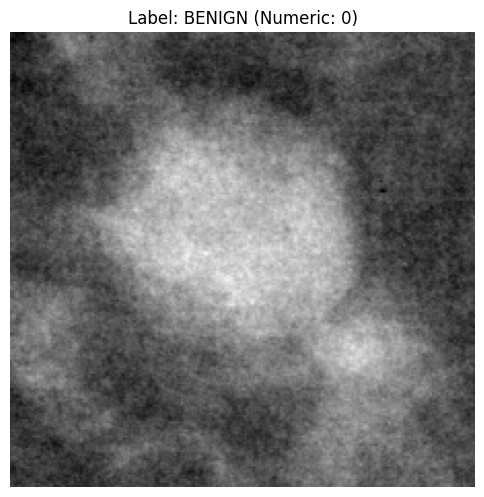

In [21]:
import matplotlib.pyplot as plt
import random
import tensorflow as tf # For image loading, though PIL or OpenCV could also be used

# Use model_input_df if it exists and is populated, otherwise fall back to final_training_df
df_to_plot_from = pd.DataFrame()
if 'model_input_df' in globals() and not model_input_df.empty:
    df_to_plot_from = model_input_df
    print("Plotting from model_input_df.")
elif 'final_training_df' in globals() and not final_training_df.empty:
    df_to_plot_from = final_training_df
    print("Plotting from final_training_df (model_input_df not found or empty).")
else:
    print("Error: Neither model_input_df nor final_training_df is available for plotting.")

if not df_to_plot_from.empty:
    # Select a random image
    random_index = random.randint(0, len(df_to_plot_from) - 1)
    sample_row = df_to_plot_from.iloc[random_index]
    image_path_to_plot = sample_row['image_path']
    label_to_plot = sample_row['label']

    print(f"Plotting image: {image_path_to_plot}")
    print(f"Label: {'MALIGNANT' if label_to_plot == 1 else 'BENIGN'} (Numeric: {label_to_plot})")

    try:
        # Load the image using TensorFlow
        image_tensor = tf.io.read_file(image_path_to_plot)
        image_tensor = tf.image.decode_jpeg(image_tensor, channels=3) # Decode as RGB

        # Display the image
        plt.figure(figsize=(6, 6))
        plt.imshow(image_tensor.numpy().astype("uint8")) # Convert to uint8 for display
        plt.title(f"Label: {'MALIGNANT' if label_to_plot == 1 else 'BENIGN'} (Numeric: {label_to_plot})")
        plt.axis("off")
        plt.show()
    except Exception as e:
        print(f"Error loading or displaying image {image_path_to_plot}: {e}")
else:
    print("Cannot plot image as the DataFrame is empty.")


In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# --- Configuration for Data Preparation ---
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMAGE_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 32 # You can adjust this based on your system's memory
RANDOM_STATE = 42 # For reproducibility
TEST_SPLIT_SIZE = 0.2 # 20% for validation

# Check if model_input_df exists and is not empty
if 'model_input_df' in globals() and not model_input_df.empty:
    print(f"--- Task 1: Finalizing Data Preparation ---")
    print(f"Using model_input_df with {len(model_input_df)} entries for splitting.")
    
    # 1. Split the data into training and validation sets
    # We'll stratify by 'label' to ensure similar class distribution in both sets.
    try:
        train_df, val_df = train_test_split(
            model_input_df, # Use the cleaned DataFrame
            test_size=TEST_SPLIT_SIZE,
            stratify=model_input_df['label'], # Stratify based on the 'label' column
            random_state=RANDOM_STATE
        )
        print(f"\nSuccessfully split data:")
        print(f"Training set size: {len(train_df)}")
        print(f"Validation set size: {len(val_df)}")
        print("\nTraining set label distribution:")
        print(train_df['label'].value_counts(normalize=True))
        print("\nValidation set label distribution:")
        print(val_df['label'].value_counts(normalize=True))

    except ValueError as e:
        print(f"\nError during stratified train_test_split: {e}")
        print("This can happen if a class has too few members for stratification with the given test_size.")
        print("Attempting split without stratification...")
        train_df, val_df = train_test_split(
            model_input_df,
            test_size=TEST_SPLIT_SIZE,
            random_state=RANDOM_STATE
        )
        print(f"\nSuccessfully split data (without stratification):")
        print(f"Training set size: {len(train_df)}")
        print(f"Validation set size: {len(val_df)}")
        print("\nTraining set label distribution:")
        print(train_df['label'].value_counts(normalize=True))
        print("\nValidation set label distribution:")
        print(val_df['label'].value_counts(normalize=True))


    # 2. Image Loading and Preprocessing Function
    def load_and_preprocess_image(image_path, label):
        # Read the image file
        image = tf.io.read_file(image_path)
        # Decode JPEG image
        image = tf.image.decode_jpeg(image, channels=3) # Decode as 3 channels (RGB)
        # Resize the image
        image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
        # Preprocess for MobileNetV2 (scales pixel values to [-1, 1])
        image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
        return image, label

    # 3. Create TensorFlow Datasets
    # Training Dataset
    if not train_df.empty:
        train_image_paths = train_df['image_path'].values
        train_labels = train_df['label'].values

        train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
        train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        train_dataset = train_dataset.shuffle(buffer_size=len(train_df), seed=RANDOM_STATE, reshuffle_each_iteration=True)
        train_dataset = train_dataset.batch(BATCH_SIZE)
        train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE) # Optimize performance
        print("\nTraining dataset created successfully.")
    else:
        print("\nTraining DataFrame is empty. Cannot create training dataset.")
        train_dataset = None

    # Validation Dataset
    if not val_df.empty:
        val_image_paths = val_df['image_path'].values
        val_labels = val_df['label'].values

        val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_labels))
        val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        val_dataset = val_dataset.batch(BATCH_SIZE) # No need to shuffle validation data
        val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        print("Validation dataset created successfully.")
    else:
        print("\nValidation DataFrame is empty. Cannot create validation dataset.")
        val_dataset = None
        
    # Inspect a batch from the training dataset
    if train_dataset:
        print("\nInspecting a batch from the training dataset:")
        for images, labels in train_dataset.take(1): # Take one batch
            print(f"  Images batch shape: {images.shape}") # (BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3)
            print(f"  Labels batch shape: {labels.shape}") # (BATCH_SIZE,)
            print(f"  Sample image min/max pixel values (after preprocessing): {tf.reduce_min(images[0]).numpy()}, {tf.reduce_max(images[0]).numpy()}")
            print(f"  Sample labels from batch: {labels.numpy()[:5]}")
else:
    print("Error: model_input_df is not defined or is empty. Cannot proceed with Task 1.")
    # Define placeholders to prevent errors in subsequent cells if this block fails
    train_df, val_df = pd.DataFrame(), pd.DataFrame()
    train_dataset, val_dataset = None, None


--- Task 1: Finalizing Data Preparation ---
Using model_input_df with 2863 entries for splitting.

Successfully split data:
Training set size: 2290
Validation set size: 573

Training set label distribution:
label
0    0.587336
1    0.412664
Name: proportion, dtype: float64

Validation set label distribution:
label
0    0.588133
1    0.411867
Name: proportion, dtype: float64

Training dataset created successfully.
Validation dataset created successfully.

Inspecting a batch from the training dataset:
  Images batch shape: (32, 224, 224, 3)
  Labels batch shape: (32,)
  Sample image min/max pixel values (after preprocessing): -0.9952994585037231, 0.9980392456054688
  Sample labels from batch: [1 0 0 0 1]


In [24]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall

# --- Task 2: Model Definition (MobileNetV2) ---
IMG_SHAPE = (224, 224, 3) # Input shape expected by MobileNetV2

# 1. Load the MobileNetV2 base model
base_model = MobileNetV2(
    weights='imagenet', # Use pre-trained weights from ImageNet
    include_top=False,  # Exclude the top classification layer
    input_shape=IMG_SHAPE
)

In [25]:
# 2. Freeze the base model's layers
base_model.trainable = False
print(f"Base model (MobileNetV2) loaded with {len(base_model.layers)} layers. All layers are frozen.")

Base model (MobileNetV2) loaded with 154 layers. All layers are frozen.


In [26]:
# 3. Add a custom classification head
# This head will be responsible for binary classification
custom_head = Sequential([
    GlobalAveragePooling2D(), # Flatten the feature maps from the base model
    Dropout(0.2),             # Regularization to prevent overfitting
    Dense(1, activation='sigmoid') # Binary classification (output: probability of class 1)
])

# Combine the base model and the custom head
model = Model(inputs=base_model.input, outputs=custom_head(base_model.output))
print("Custom classification head added on top of the base model.")

Custom classification head added on top of the base model.


In [27]:
# 4. Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001), # Adam optimizer with a default learning rate
    loss=BinaryCrossentropy(),          # Binary crossentropy for binary classification
    metrics=['accuracy', Precision(), Recall()] # Accuracy, Precision, and Recall
)
print("Model compiled successfully.")

Model compiled successfully.


In [28]:
# Summary of the model
print("\n--- Model Summary ---")
model.summary()


--- Model Summary ---
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         [

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# --- Task 3: Model Training ---

# 1. Define callbacks
callbacks = [
    ModelCheckpoint(
        filepath="best_model.h5", # Save the best model to this file
        monitor="val_loss",       # Monitor validation loss
        save_best_only=True,      # Save only the best model
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",       # Stop training if validation loss doesn't improve
        patience=5,               # Number of epochs to wait before stopping
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",       # Reduce learning rate if validation loss plateaus
        factor=0.5,               # Reduce learning rate by half
        patience=3,               # Number of epochs to wait before reducing
        verbose=1
    )
]

In [30]:
# 2. Train the model
EPOCHS = 20 # You can adjust this based on your dataset and hardware
history = model.fit(
    train_dataset,               # Training dataset
    validation_data=val_dataset, # Validation dataset
    epochs=EPOCHS,               # Number of epochs
    callbacks=callbacks,         # Callbacks for monitoring and saving
    verbose=1                    # Print progress during training
)

Epoch 1/20


72/72 [==============================] - ETA: 0s - loss: 0.7516 - accuracy: 0.5690 - precision_1: 0.4752 - recall_1: 0.4265
Epoch 1: val_loss improved from inf to 0.57687, saving model to best_model.h5


d:\Computer Science\UoL\Final Project\Prototype\bcdvenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - 57s 497ms/step - loss: 0.7516 - accuracy: 0.5690 - precision_1: 0.4752 - recall_1: 0.4265 - val_loss: 0.5769 - val_accuracy: 0.6946 - val_precision_1: 0.6344 - val_recall_1: 0.6102 - lr: 0.0010
Epoch 2/20
72/72 [==============================] - ETA: 0s - loss: 0.6354 - accuracy: 0.6341 - precision_1: 0.5656 - recall_1: 0.4878
Epoch 2: val_loss improved from 0.57687 to 0.55278, saving model to best_model.h5
72/72 [==============================] - 49s 451ms/step - loss: 0.6354 - accuracy: 0.6341 - precision_1: 0.5656 - recall_1: 0.4878 - val_loss: 0.5528 - val_accuracy: 0.7120 - val_precision_1: 0.6859 - val_recall_1: 0.5551 - lr: 0.0010
Epoch 3/20
72/72 [==============================] - ETA: 0s - loss: 0.6048 - accuracy: 0.6755 - precision_1: 0.6220 - recall_1: 0.5450
Epoch 3: val_loss improved from 0.55278 to 0.53738, saving model to best_model.h5
72/72 [==============================] - 35s 453ms/step - loss: 0.6048 - accuracy: 0.6755 - prec


--- Training Complete ---
Training history keys: dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1', 'lr'])


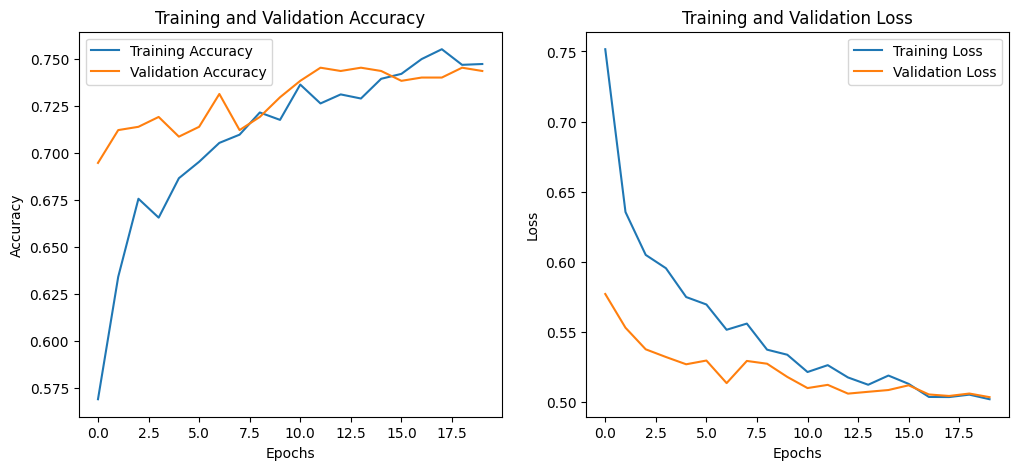

In [31]:
# 3. Store training history
print("\n--- Training Complete ---")
print("Training history keys:", history.history.keys())

# Optional: Plot training and validation accuracy/loss curves
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Call the function to plot training history
plot_training_history(history)

In [33]:
# Print final training and validation accuracy and loss
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print("\n--- Final Training Stats ---")
print(f"Training Accuracy: {final_train_accuracy:.4f}")
print(f"Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Training Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")


--- Final Training Stats ---
Training Accuracy: 0.7472
Validation Accuracy: 0.7435
Training Loss: 0.5018
Validation Loss: 0.5032


# Evaluate the model

In [38]:
# Load the test CSVs into DataFrames and concatenate them
mass_test_df = pd.read_csv(MASS_TEST_PATH)
calc_test_df = pd.read_csv(CALC_TEST_PATH)

# Concatenate the two DataFrames
test_df = pd.concat([mass_test_df, calc_test_df], ignore_index=True)

print(f"Combined test_df shape: {test_df.shape}")
print(test_df.head())

Combined test_df shape: (704, 17)
  patient_id  breast_density left or right breast image view  abnormality id  \
0    P_00016             4.0                 LEFT         CC               1   
1    P_00016             4.0                 LEFT        MLO               1   
2    P_00017             2.0                 LEFT         CC               1   
3    P_00017             2.0                 LEFT        MLO               1   
4    P_00032             3.0                RIGHT         CC               1   

  abnormality type mass shape   mass margins  assessment  pathology  subtlety  \
0             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
1             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
2             mass      ROUND  CIRCUMSCRIBED           4  MALIGNANT         4   
3             mass      ROUND    ILL_DEFINED           4  MALIGNANT         4   
4             mass      ROUND       OBSCURED           0     BENIGN         2   

In [40]:
# --- Preparing the Test Dataset ---

# 1. Process the test CSVs
print("\n--- Processing mass_case_description_test_set.csv ---")
mass_test_df_processed = get_jpeg_paths_and_labels_revised(
    mass_test_df, # Replace with the actual DataFrame for mass test cases
    patient_id_col_original_df='patient_id', # Column for patient ID
    dicom_path_col='cropped image file path', # Column for cropped image paths
    pathology_col='pathology', # Column for pathology labels
    case_id_dict=case_identifier_to_jpeg_path_dict # Use the mapping dictionary
)

print("\n--- Processing calc_case_description_test_set.csv ---")
calc_test_df_processed = get_jpeg_paths_and_labels_revised(
    calc_test_df, # Replace with the actual DataFrame for calc test cases
    patient_id_col_original_df='patient_id', # Column for patient ID
    dicom_path_col='cropped image file path', # Column for cropped image paths
    pathology_col='pathology', # Column for pathology labels
    case_id_dict=case_identifier_to_jpeg_path_dict # Use the mapping dictionary
)


--- Processing mass_case_description_test_set.csv ---

--- Debugging get_jpeg_paths_and_labels_revised (first few rows) ---
Total rows to process: 378
Size of case_id_dict: 3567

Row 0, Original Patient ID: P_00016
  DICOM path string from CSV: Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.259596319110047779433501728143778409887/1.3.6.1.4.1.9590.100.1.2.30820586311062570442302321942433426184/000000.dcm
  Extracted Case ID Key for lookup: Mass-Test_P_00016_LEFT_CC_1
  Found in case_id_dict. Mapped JPEG Path: d:\Computer Science\UoL\Final Project\Prototype\data\kaggle\jpeg\1.3.6.1.4.1.9590.100.1.2.30820586311062570442302321942433426184\2-272.jpg
  SUCCESS: JPEG path exists.

Row 1, Original Patient ID: P_00016
  DICOM path string from CSV: Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.207144238612220754118040203520552715563/1.3.6.1.4.1.9590.100.1.2.381440141511137044327302306604206077287/000000.dcm
  Extracted Case ID Key for lookup: Mass-Test_P_00016_LEFT_MLO_1
  Found i

In [41]:
# 2. Combine and finalize the test dataset
print("\n--- Combining and Finalizing Test Data ---")
final_test_df = pd.concat([mass_test_df_processed, calc_test_df_processed], ignore_index=True)
print(f"Total entries after combining: {len(final_test_df)}")

# Ensure 'image_path' is not NaN and drop duplicates
final_test_df.dropna(subset=['image_path'], inplace=True)
final_test_df.drop_duplicates(subset=['image_path'], keep='first', inplace=True)
print(f"Entries after removing NaNs and duplicates: {len(final_test_df)}")

# Define pathology mapping to numerical labels
pathology_map = {
    'MALIGNANT': 1,
    'BENIGN': 0,
    'BENIGN_WITHOUT_CALLBACK': 0
}
final_test_df['label'] = final_test_df['pathology'].map(pathology_map)

# Keep only rows where 'label' could be mapped (i.e., pathology was one of the expected types)
# and 'image_path' is valid
final_test_df = final_test_df.dropna(subset=['label', 'image_path']).copy()
final_test_df['label'] = final_test_df['label'].astype(int)

print(f"\nFinal test dataset size: {len(final_test_df)} entries.")
print("Columns in final_test_df:", final_test_df.columns)
print("\n--- Final Test DataFrame Head ---")
print(final_test_df.head())
print("\n--- Label Distribution in Final Test DataFrame ---")
print(final_test_df['label'].value_counts(dropna=False))


--- Combining and Finalizing Test Data ---
Total entries after combining: 704
Entries after removing NaNs and duplicates: 704

Final test dataset size: 704 entries.
Columns in final_test_df: Index(['patient_id', 'image_path', 'pathology', 'case_id_from_path', 'label'], dtype='object')

--- Final Test DataFrame Head ---
  patient_id                                         image_path  pathology  \
0    P_00016  d:\Computer Science\UoL\Final Project\Prototyp...  MALIGNANT   
1    P_00016  d:\Computer Science\UoL\Final Project\Prototyp...  MALIGNANT   
2    P_00017  d:\Computer Science\UoL\Final Project\Prototyp...  MALIGNANT   
3    P_00017  d:\Computer Science\UoL\Final Project\Prototyp...  MALIGNANT   
4    P_00032  d:\Computer Science\UoL\Final Project\Prototyp...     BENIGN   

              case_id_from_path  label  
0   Mass-Test_P_00016_LEFT_CC_1      1  
1  Mass-Test_P_00016_LEFT_MLO_1      1  
2   Mass-Test_P_00017_LEFT_CC_1      1  
3  Mass-Test_P_00017_LEFT_MLO_1      1  
4  M

In [42]:
# 3. Create TensorFlow Dataset for Testing
print("\n--- Creating Test Dataset ---")
if not final_test_df.empty:
    test_image_paths = final_test_df['image_path'].values
    test_labels = final_test_df['label'].values

    test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths, test_labels))
    test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE) # Batch the test data
    test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE) # Optimize performance
    print("Test dataset created successfully.")
else:
    print("Final test DataFrame is empty. Cannot create test dataset.")
    test_dataset = None


--- Creating Test Dataset ---
Test dataset created successfully.


In [43]:
# --- Evaluating the Model ---
if test_dataset:
    print("\n--- Evaluating the Model on Test Dataset ---")
    test_results = model.evaluate(test_dataset, verbose=1)
    print("\nTest Results:")
    print(f"Loss: {test_results[0]:.4f}")
    print(f"Accuracy: {test_results[1]:.4f}")
    print(f"Precision: {test_results[2]:.4f}")
    print(f"Recall: {test_results[3]:.4f}")
else:
    print("Test dataset is not available. Cannot evaluate the model.")


--- Evaluating the Model on Test Dataset ---
22/22 [==============================] - 8s 354ms/step - loss: 0.5957 - accuracy: 0.6634 - precision_1: 0.5704 - recall_1: 0.5725

Test Results:
Loss: 0.5957
Accuracy: 0.6634
Precision: 0.5704
Recall: 0.5725



--- Generating Predictions ---
1/1 [==============================] - 0s 363ms/step

--- Confusion Matrix ---
Confusion Matrix:
[[309 119]
 [118 158]]


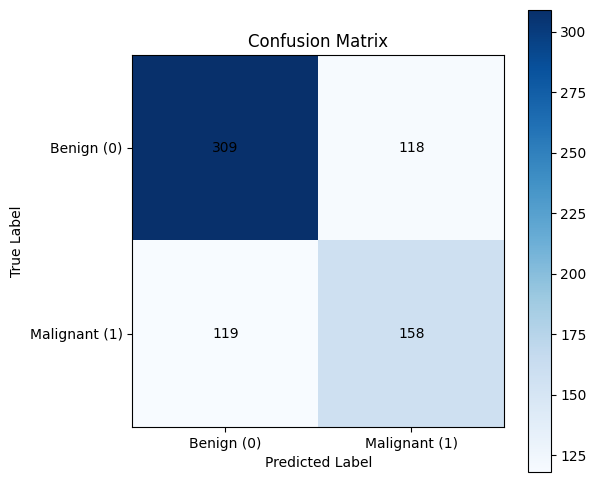


--- Classification Report ---
              precision    recall  f1-score   support

      Benign       0.72      0.72      0.72       428
   Malignant       0.57      0.57      0.57       276

    accuracy                           0.66       704
   macro avg       0.65      0.65      0.65       704
weighted avg       0.66      0.66      0.66       704


--- ROC Curve and AUC ---
AUC Score: 0.7231


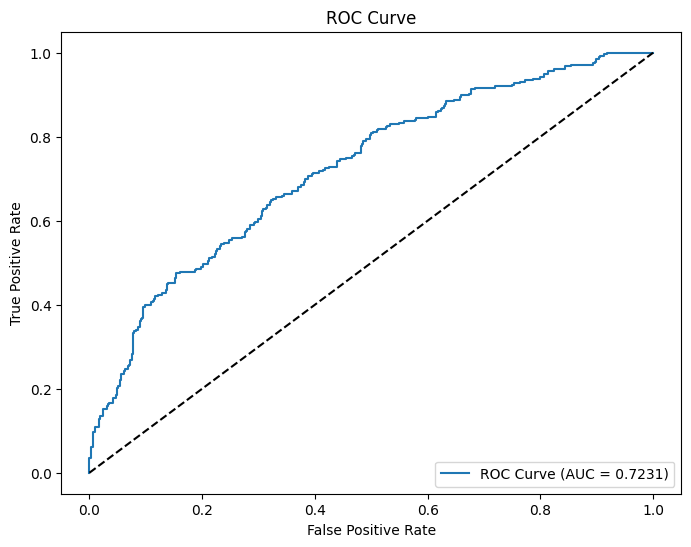

In [44]:
# Ensure test_dataset and model are defined and populated.

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# --- Task 5: Reporting Metrics ---

# 1. Get predictions and true labels from the test dataset
print("\n--- Generating Predictions ---")
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy()) # True labels
    y_pred.extend(predictions.flatten()) # Predicted probabilities

# Convert to NumPy arrays for further processing
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Calculate confusion matrix
print("\n--- Confusion Matrix ---")
threshold = 0.5 # Threshold for binary classification
y_pred_binary = (y_pred >= threshold).astype(int) # Convert probabilities to binary predictions
conf_matrix = confusion_matrix(y_true, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Benign (0)', 'Malignant (1)'])
plt.yticks([0, 1], ['Benign (0)', 'Malignant (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.text(0, 0, conf_matrix[0, 0], ha='center', va='center', color='black')
plt.text(0, 1, conf_matrix[0, 1], ha='center', va='center', color='black')
plt.text(1, 0, conf_matrix[1, 0], ha='center', va='center', color='black')
plt.text(1, 1, conf_matrix[1, 1], ha='center', va='center', color='black')
plt.show()

# 3. Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred_binary, target_names=['Benign', 'Malignant']))

# 4. Calculate ROC Curve and AUC
print("\n--- ROC Curve and AUC ---")
fpr, tpr, thresholds = roc_curve(y_true, y_pred) # Use probabilities for ROC
roc_auc = auc(fpr, tpr)
print(f"AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--') # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()